### Effective Energy Shift Algorithm for Electric Energy Storage Analysis

This notebook is intended as an interactive playground to foster the understanding of the Effective Energy Shift (EfES) algorithm.

#### Import modules and define functions for visualization

In [1]:
import ipywidgets as widgets
from ipywidgets import interact, interactive_output, fixed, interact_manual
import copy

import numpy as np
import pandas as pd

import effective_energy_shift as efes
import efes_dataclasses as efes_dc
import math_energy_systems as mes
import efes_plotting as efes_plt

style_widgets = dict(description_width='initial', handle_color='lightblue')

def create_intermediate_result_player(intermediate_results, efficiency_discharging):
    widget_intermediate_result_play = widgets.Play(
        value=len(intermediate_results)-1,
        min=0,
        max=len(intermediate_results)-1,
        step=1,
        interval=1000,
        description="Press play",
        disabled=False
    )
    widget_intermediate_result_index=widgets.IntSlider(
        value=len(intermediate_results)-1,
        min=0,
        max=len(intermediate_results)-1,
        step=1,
        style = style_widgets,
        continuous_update=True,
        orientation='horizontal',
        readout=True
    )
    widgets.jslink((widget_intermediate_result_play, 'value'), (widget_intermediate_result_index, 'value'))

    def show_intermediate_result(intermediate_result_index):
        efes_plt.plot_energy_packets(*(intermediate_results[intermediate_result_index]), efficiency_discharging)

    ui = widgets.VBox([widgets.Label('Use the player or slider to scroll through the performed steps:'), widgets.HBox([widget_intermediate_result_play,widget_intermediate_result_index])])

    out = interactive_output(show_intermediate_result, dict(intermediate_result_index=widget_intermediate_result_index))
    display(ui,out)

    
current_results = None

def create_widget(widget_type, description, initial_value, **kwargs):
    if widget_type == 'Checkbox':
        return widgets.Checkbox(
            value=initial_value,
            description=description,
            disabled=False,
            indent=False,
            style = style_widgets,
            **kwargs
        )
    if widget_type == 'FloatText':
        return widgets.FloatText(
            value=initial_value,
            description=description,
            style = style_widgets,
            disabled=False,
            **kwargs
        )
    if widget_type == 'FloatSlider':
        return widgets.FloatSlider(
            value=initial_value,
            description=description,
            style = style_widgets,
            continuous_update=True,
            readout=True,
            readout_format='.2f',
            **kwargs
        )

def create_ui_from_descr(ui_descr, widget_dict):
    v_box_entries = []
    for v_box_descr in ui_descr:
        if isinstance(v_box_descr, str):
            v_box_entries.append(widget_dict[v_box_descr])
        else:
            h_box_entries = []
            for h_box_descr in v_box_descr:
                h_box_entries.append(widget_dict[h_box_descr])
            v_box_entries.append(widgets.HBox(h_box_entries))
    return widgets.VBox(v_box_entries)

def create_ui(power_generation, power_demand, delta_time_step):
    energy_generation_original = power_generation.sum()
    power_generation_normalized = power_generation/energy_generation_original

    energy_demand_original = power_demand.sum()
    power_demand_normalized = power_demand/energy_demand_original

    intermediate_results = []

    def callback_between_steps(current_step, phases, mask, intermediate_results):
        intermediate_results.append((current_step, copy.deepcopy(phases), copy.deepcopy(mask)))

    def update(energy_demand, energy_generation, efficiency_charging, efficiency_discharging, efficiency_direct_usage, add_plot_input, add_plot_intermediate_steps, add_plot_results):
        global intermediate_results, current_results
        intermediate_results = []
        power_generation_rescaled = energy_generation*power_generation_normalized
        power_demand_rescaled = energy_demand*power_demand_normalized

        current_results = efes.perform_effective_energy_shift(
            power_generation=power_generation_rescaled,
            power_demand=power_demand_rescaled,
            delta_time_step=delta_time_step,
            power_max_charging=np.inf,
            efficiency_direct_usage=efficiency_direct_usage,
            efficiency_charging=efficiency_charging,
            efficiency_discharging=efficiency_discharging,
            callback_between_steps=callback_between_steps,
            callback_kwargs=dict(intermediate_results=intermediate_results)
        )

        if add_plot_input:
            efes_plt.plot_input(current_results)
        if add_plot_intermediate_steps:
            create_intermediate_result_player(intermediate_results, efficiency_discharging)
        if add_plot_results:
            efes_plt.plot_results(current_results)

    widget_dict = dict(
        energy_demand               = create_widget(widget_type='FloatText', description='energy demand:', initial_value=energy_demand_original),
        energy_generation           = create_widget(widget_type='FloatText', description='energy generation:', initial_value=energy_generation_original),
        efficiency_charging         = create_widget(widget_type='FloatSlider', description='efficiency charging:', initial_value=1.0, min=0.1, max=1.0, step=0.01, orientation='horizontal' ),
        efficiency_discharging      = create_widget(widget_type='FloatSlider', description='efficiency discharging:', initial_value=1.0, min=0.1, max=1.0, step=0.01, orientation='horizontal' ),
        efficiency_direct_usage     = create_widget(widget_type='FloatSlider', description='efficiency direct usage:', initial_value=1.0, min=0.1, max=1.0, step=0.01, orientation='horizontal' ),
        add_plot_input              = create_widget(widget_type='Checkbox', description='Plot input', initial_value=False),
        add_plot_intermediate_steps = create_widget(widget_type='Checkbox', description='Plot intermediate steps', initial_value=False),
        add_plot_results            = create_widget(widget_type='Checkbox', description='Plot results', initial_value=True)
    )

    ui_descr = [['energy_demand', 'energy_generation'], ['efficiency_direct_usage', 'efficiency_charging', 'efficiency_discharging'], 'add_plot_input', 'add_plot_intermediate_steps', 'add_plot_results']
    ui = create_ui_from_descr(ui_descr, widget_dict)

    out = interactive_output(update, widget_dict)
    
    return ui, out

#### Interactive example from the publication

In [2]:
power_generation = np.array([2,3,2,4,3,1,0,0,2,5,6,2,1,0,1,2,3,2,0,0,4,4,4,2])
power_demand = np.array([1,4,1,2,1,2,4,5,0,1,3,1,2,2,1,1,2,3,4,5,2,1,5,1])
delta_time_step = 1.0
ui, out = create_ui(power_generation, power_demand, delta_time_step)
display(ui,out)

Output()

Loading from parameter_study/00/results.pickle
Loading from parameter_study/01/results.pickle
Loading from parameter_study/02/results.pickle
Loading from parameter_study/03/results.pickle
Loading from parameter_study/04/results.pickle
Loading from parameter_study/05/results.pickle
Loading from parameter_study/06/results.pickle
Loading from parameter_study/07/results.pickle
Loading from parameter_study/08/results.pickle
Loading from parameter_study/09/results.pickle
Loading from parameter_study/10/results.pickle
Loading from parameter_study/11/results.pickle
Loading from parameter_study/12/results.pickle
Loading from parameter_study/13/results.pickle
Loading from parameter_study/14/results.pickle
Loading from parameter_study/15/results.pickle
Loading from parameter_study/16/results.pickle
Loading from parameter_study/17/results.pickle
Loading from parameter_study/18/results.pickle
Loading from parameter_study/19/results.pickle
Loading from parameter_study/20/results.pickle
All finished


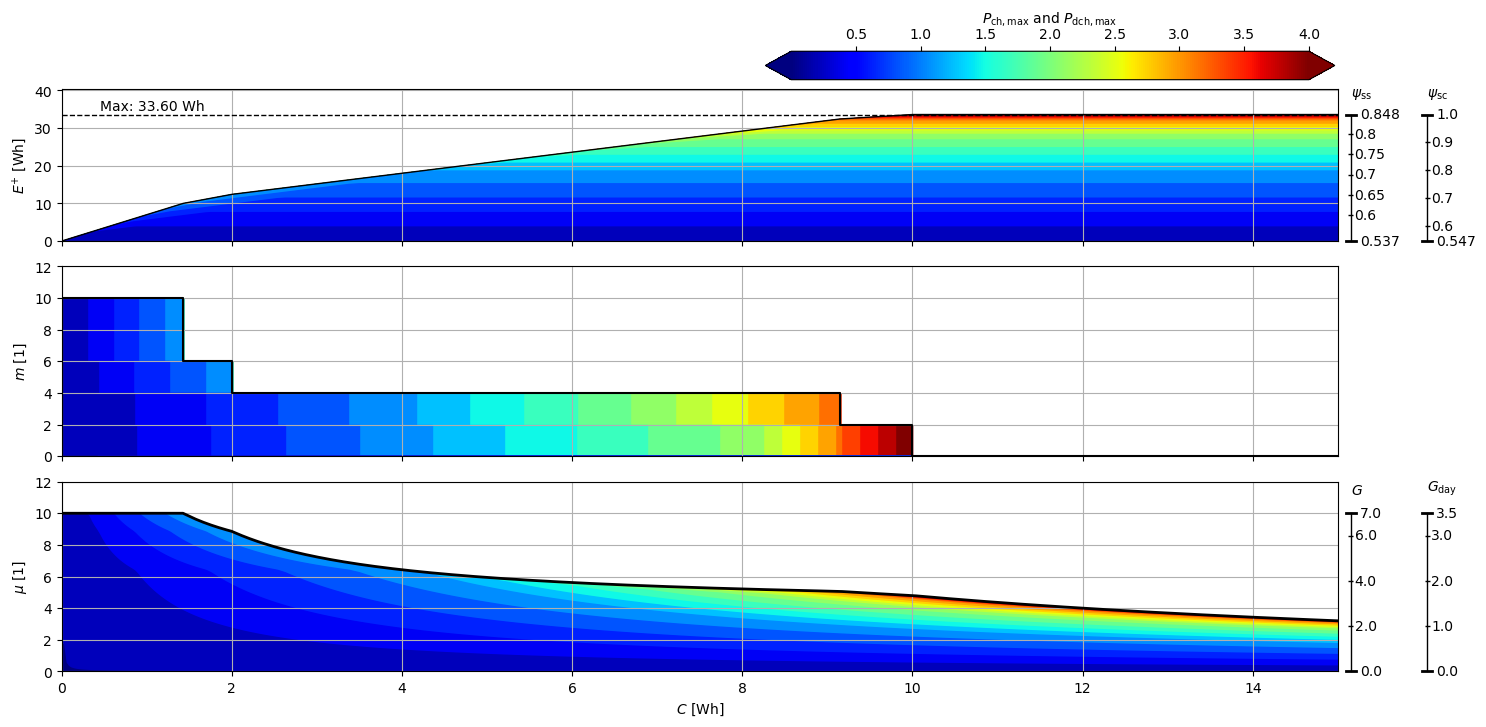

In [3]:
power_generation = np.array([2,3,2,4,3,1,0,0,2,5,6,2,1,0,1,2,3,2,0,0,4,4,4,2,2,3,2,4,3,1,0,0,2,5,6,2,1,0,1,2,3,2,0,0,4,4,4,2])
power_demand = np.array([1,4,1,2,1,2,4,5,0,1,3,1,2,2,1,1,2,3,4,5,2,1,5,1,1,4,1,2,1,2,4,5,0,1,3,1,2,2,1,1,2,3,4,5,2,1,5,1])
delta_time_step = 1.0

parameter_study_results = efes.run_parameter_study(
    power_generation=power_generation,
    power_demand=power_demand,
    delta_time_step=delta_time_step,
    efficiency_direct_usage=1.0,
    efficiency_discharging=0.7,
    efficiency_charging=1.0,
    parameter_variation=pd.DataFrame(data=dict(
        power_max_discharging=np.array([*np.linspace(0.001, 4, 20), np.inf]),
        power_max_charging=np.array([*np.linspace(0.001, 4, 20), np.inf]),
    )),
    result_dir='parameter_study'
)

efes_plt.create_variation_plot(parameter_study_results,
                        cmap_parameter_name = 'power_max_discharging',
                        cbar_label = '$\mathit{P}_{\mathrm{ch,max}}$ and $\mathit{P}_{\mathrm{dch,max}}$',
                        index_reference_result = -1,
                        use_fill = True,
                        cmap_name = 'jet',
                        add_self_sufficiency_axes=True,
                        add_self_consumption_axes=True,
                        add_local_effectiveness_plot = True,
                        add_effectiveness_plot=True,
                        add_gain_axes = True,
                        add_gain_per_day_axes= True,
                        show = True,
                     )